<a href="https://colab.research.google.com/github/Snake-AID/SnakeAid.ComputerVision/blob/main/SnakeTraining_V4_YOLOv12_Khiem_Bbox5000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [1]:
!nvidia-smi

Sat Dec 13 12:38:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import os
from datetime import datetime, timedelta, timezone

HOME = os.getcwd()
print(f"📂 HOME: {HOME}")

PROJECT_NAME = "SnakeTraining"
VERSION      = "V4"
MODEL_ARCH   = "YOLOv12"
AUTHOR       = "Khiem"
DATA_INFO    = "Bbox5000"

# Lấy thời gian hiện tại theo múi giờ UTC+7
utc_plus_7 = timezone(timedelta(hours=7))
current_time = datetime.now(utc_plus_7).strftime("%Y%m%d_%H%M")

# Ghép chuỗi tên model kèm timestamp
notebook_name = f"{PROJECT_NAME}_{VERSION}_{MODEL_ARCH}_{AUTHOR}_{DATA_INFO}_{current_time}"

print(f"📘 Configured Model Name: {notebook_name}")

📂 HOME: /content
📘 Configured Model Name: SnakeTraining_V4_YOLOv12_Khiem_Bbox5000_20251213_1938


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Dataset Paths

In [4]:
import os
import shutil
import yaml
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

# --- CONFIG ---
DRIVE_DATASET_PATH = '/content/drive/MyDrive/SnakeDataset/SnakeAid-YOLOv12-5000bbox'
DATASET_PATH = '/content/snake_dataset'
DATA_YAML_PATH = f'{DATASET_PATH}/data.yaml'

def check_dataset_integrity(path):
    """Kiểm tra thông minh: Trả về True nếu data đã đầy đủ"""
    # 1. Check file cấu hình
    if not os.path.exists(f"{path}/data.yaml"):
        return False

    # 2. Check các folder quan trọng (train, valid, test)
    # Nếu bất kỳ folder nào thiếu hoặc rỗng -> coi như lỗi -> copy lại
    required_dirs = [
        'train/images', 'train/labels',
        'valid/images', 'valid/labels',
        'test/images', 'test/labels'
    ]

    for d in required_dirs:
        dir_path = os.path.join(path, d)
        if not os.path.exists(dir_path):
            return False
        if not os.listdir(dir_path): # Folder rỗng
            return False

    return True

def copy_file_worker(args):
    """Hàm worker để copy 1 file (dùng cho đa luồng)"""
    src, dst = args
    try:
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy2(src, dst)
    except Exception as e:
        # Có thể log error nếu cần
        pass

def fast_copy_multithread(src_root, dst_root, workers=16):
    """Copy dữ liệu sử dụng đa luồng để tối ưu I/O"""
    if os.path.exists(dst_root):
        print(f"🗑️ Phát hiện dữ liệu không toàn vẹn. Đang xóa {dst_root}...")
        shutil.rmtree(dst_root)

    print("🔍 Đang quét danh sách file nguồn (Scanning)...")
    files_to_copy = []
    for root, dirs, files in os.walk(src_root):
        for file in files:
            src_file = os.path.join(root, file)
            rel_path = os.path.relpath(src_file, src_root)
            dst_file = os.path.join(dst_root, rel_path)
            files_to_copy.append((src_file, dst_file))

    print(f"🚀 Tìm thấy {len(files_to_copy)} files. Bắt đầu copy tốc độ cao (16 threads)...")

    # ThreadPoolExecutor giúp request nhiều file cùng lúc từ Drive
    with ThreadPoolExecutor(max_workers=workers) as executor:
        list(tqdm(executor.map(copy_file_worker, files_to_copy), total=len(files_to_copy), unit="file"))

# --- MAIN FLOW ---
if check_dataset_integrity(DATASET_PATH):
    print("✅ Smart Check: Dữ liệu đã đầy đủ và hợp lệ tại Local. (Skipped Copy)")
else:
    print(f"⚠️ Smart Check: Dữ liệu thiếu hoặc chưa có. Tiến hành copy...")
    try:
        fast_copy_multithread(DRIVE_DATASET_PATH, DATASET_PATH)

        # Cập nhật đường dẫn trong data.yaml
        if os.path.exists(DATA_YAML_PATH):
            with open(DATA_YAML_PATH, 'r') as f:
                data_config = yaml.safe_load(f)

            data_config['path'] = DATASET_PATH
            # Fix đường dẫn relative
            for key in ['train', 'val', 'test']:
                if key in data_config and isinstance(data_config[key], str):
                    if 'drive' in data_config[key].lower():
                        folder = 'valid' if key == 'val' else key
                        data_config[key] = f'{folder}/images'

            with open(DATA_YAML_PATH, 'w') as f:
                yaml.dump(data_config, f)
            print("✅ Cấu hình data.yaml hoàn tất!")
        else:
            print("⚠️ Không tìm thấy data.yaml sau khi copy!")

    except Exception as e:
        print(f"❌ Lỗi khi copy: {e}")

⚠️ Smart Check: Dữ liệu thiếu hoặc chưa có. Tiến hành copy...
🔍 Đang quét danh sách file nguồn (Scanning)...
🚀 Tìm thấy 10587 files. Bắt đầu copy tốc độ cao (16 threads)...


  0%|          | 0/10587 [00:00<?, ?file/s]

✅ Cấu hình data.yaml hoàn tất!


In [5]:
from rich import print
from rich.panel import Panel
from rich.table import Table
from rich import box
import os

def check_dataset(root, folders=("train", "valid", "test")):
    table = Table(
        title="Dataset Structure",
        box=box.SIMPLE_HEAD,
        show_lines=False,
        pad_edge=False
    )

    table.add_column("Component", style="bold cyan", justify="center")
    table.add_column("Status/Images", justify="center")
    table.add_column("Labels", justify="center")

    missing_files = False

    yaml_path = os.path.join(root, "data.yaml")
    yaml_exists = os.path.exists(yaml_path)

    if not yaml_exists:
        missing_files = True

    table.add_row(
        "data.yaml",
        "[green]FOUND" if yaml_exists else "[red]MISSING",
        "-"
    )

    for folder in folders:
        fp = os.path.join(root, folder)
        img = os.path.join(fp, "images")
        lbl = os.path.join(fp, "labels")

        img_exists = os.path.exists(img)
        lbl_exists = os.path.exists(lbl)

        if not img_exists or not lbl_exists:
            missing_files = True

        table.add_row(
            folder.upper(),
            "[green]FOUND" if img_exists else "[red]MISSING",
            "[green]FOUND" if lbl_exists else "[red]MISSING",
        )

    panel = Panel.fit(
        table,
        title="🐍 Snake Dataset Check",
        border_style="cyan",
        box=box.SIMPLE
    )

    print(panel)

    if missing_files:
        raise FileNotFoundError("Dataset structure is incomplete! Please check your dataset path and structure.")

check_dataset(DATASET_PATH)

         🐍 Snake Dataset Check         
           Dataset Structure            
                                        
   Component   Status/Images   Labels   
   ──────────────────────────────────   
   data.yaml       FOUND         -      
     TRAIN         FOUND       FOUND    
     VALID         FOUND       FOUND    
     TEST          FOUND       FOUND    
                                        
                                        

# Install YOLOv12 and SuperVision

## Install essential python package

In [6]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git supervision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 16.2 MB/s eta 0:00:00


# Test the base models

### Download example data

In [7]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-12-13 12:46:14--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-12-13 12:46:14 (135 MB/s) - ‘dog.jpeg’ saved [106055/106055]



### Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:01<00:00, 38.1MB/s]


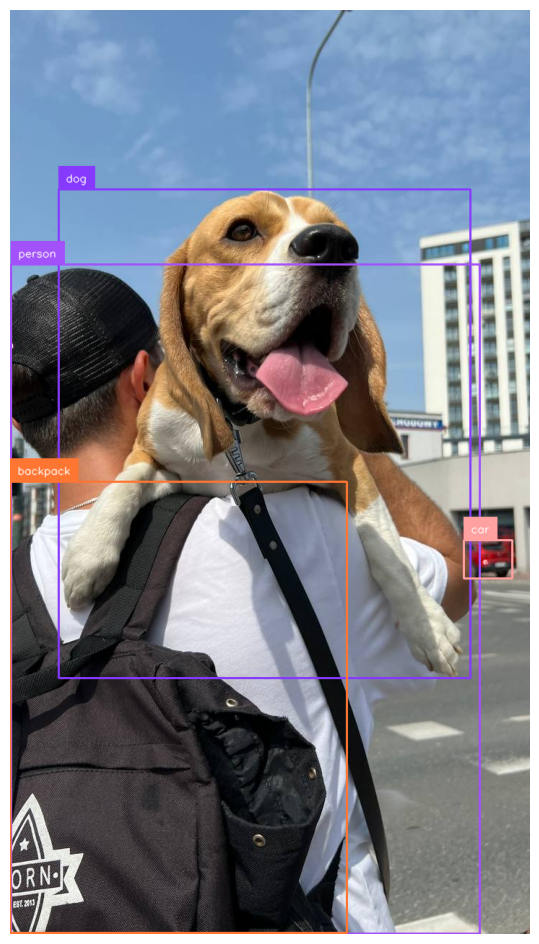

In [8]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

# Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [9]:
# from ultralytics import YOLO

# model = YOLO('yolov12m.pt')
# results = model.train(data=DATA_YAML_PATH, epochs=100, patience=10, cache=True)

### Param Config
Chúng ta fine-tune YOLO từ checkpoint pretrained (`yolov12m.pt`) thay vì train từ đầu bằng `.yaml`, nhằm tận dụng transfer learning để đạt kết quả tốt và ổn định hơn cho bài toán nhận diện rắn.

---

#### `epochs=200`

* **Chức năng:** Xác định số vòng lặp huấn luyện tối đa mà mô hình sẽ chạy trên toàn bộ tập dữ liệu.
* **Lý do lựa chọn:** Với đối tượng rắn thường nhỏ và khó phân biệt với nền, các chỉ số như mAP và Recall thường cải thiện muộn, vì vậy cần nhiều epoch hơn mức mặc định (100) để mô hình hội tụ đầy đủ.

---

#### `patience=40`

* **Chức năng:** Điều khiển cơ chế early stopping, mô hình sẽ dừng huấn luyện nếu metric validation không cải thiện sau số epoch này.
* **Lý do lựa chọn:** Trong bài toán SnakeAid, metric thường dao động mạnh do vật thể nhỏ và nền phức tạp, nên đặt patience cao để tránh dừng huấn luyện quá sớm khi mô hình chưa đạt trạng thái tối ưu.

---

#### `imgsz=896`

* **Chức năng:** Thiết lập độ phân giải ảnh đầu vào cho quá trình huấn luyện.
* **Lý do lựa chọn:** Rắn trong ảnh thường chiếm rất ít pixel, tăng độ phân giải giúp mô hình giữ lại nhiều chi tiết không gian hơn, từ đó cải thiện khả năng phát hiện rắn nhỏ hoặc ở xa.

---

#### `batch=16`

* **Chức năng:** Xác định số lượng ảnh được xử lý trong một bước cập nhật gradient.
* **Lý do lựa chọn:** Batch size vừa phải giúp cân bằng giữa độ ổn định của gradient và khả năng học các vật thể nhỏ, tránh hiện tượng làm mượt quá mức khi batch quá lớn.

---

#### `cache=True`

* **Chức năng:** Lưu dữ liệu huấn luyện vào bộ nhớ đệm để tăng tốc độ đọc dữ liệu.
* **Lý do lựa chọn:** Dataset được lưu trên Google Drive khi train bằng Colab, việc bật cache giúp giảm độ trễ I/O và rút ngắn thời gian huấn luyện tổng thể.

---

#### `workers=8`

* **Chức năng:** Xác định số tiến trình CPU song song được sử dụng để đọc dữ liệu, tiền xử lý ảnh và áp dụng các augmentation trước khi dữ liệu được đưa vào GPU trong quá trình huấn luyện.
* **Lý do lựa chọn:** Với ảnh độ phân giải cao (`imgsz=896`) và dữ liệu lưu trên Google Drive khi huấn luyện bằng Colab A100, việc sử dụng `workers=8` giúp tận dụng hiệu quả tài nguyên CPU, tránh tình trạng GPU phải chờ dữ liệu và đảm bảo tốc độ huấn luyện ổn định cho bài toán nhận diện rắn nhỏ và ở xa.

---

#### `cos_lr=True`

* **Chức năng:** Sử dụng chiến lược giảm learning rate theo hàm cosine trong quá trình huấn luyện.
* **Lý do lựa chọn:** Cosine learning rate giúp fine-tune mượt hơn ở các epoch sau, giảm nguy cơ dao động mạnh và giúp mô hình ổn định khi tối ưu cho các vật thể nhỏ.

---

#### `mixup=0.0`

* **Chức năng:** Điều chỉnh mức độ sử dụng augmentation mixup (trộn hai ảnh và nhãn).
* **Lý do lựa chọn:** Mixup có thể tạo ra các hình ảnh không thực tế đối với đối tượng dài và mảnh như rắn, làm giảm chất lượng học, vì vậy được tắt hoàn toàn trong bài toán này.

---

#### `copy_paste=0.0`

* **Chức năng:** Điều khiển augmentation copy-paste, trong đó đối tượng được cắt và dán sang ảnh khác.
* **Lý do lựa chọn:** Copy-paste có thể tạo ra các vị trí rắn không tự nhiên trong ảnh, gây nhiễu cho mô hình, nên được tắt để giữ tính thực tế của dữ liệu huấn luyện.

In [10]:
from ultralytics import YOLO

model = YOLO("yolov12m.pt")

results = model.train(
    data=DATA_YAML_PATH,
    project=f'{HOME}/runs/detect',
    name='train',
    exist_ok=True,    # Quan trọng: Ghi đè folder cũ để các cell đánh giá bên dưới không bị lỗi đường dẫn

    epochs=17,
    # patience=40,
    imgsz=896,        # Quan trọng cho rắn nhỏ/ở xa
    batch=16,         # Phù hợp với A100. Nếu dùng T4 (Free Colab) hãy giảm xuống 8 nếu bị OOM.
    cache=True,       # Cache vào RAM giúp train cực nhanh (hiệu quả nhất khi data đã ở Local)
    workers=8,
    cos_lr=True,

    # Tắt các augmentation không thực tế với hình dáng rắn
    mixup=0.0,
    copy_paste=0.0,
)

100%|██████████| 38.0M/38.0M [00:00<00:00, 42.7MB/s]


New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov12m.pt, data=/content/snake_dataset/data.yaml, epochs=17, time=None, patience=100, batch=16, imgsz=896, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/runs/detect, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, em

100%|██████████| 755k/755k [00:00<00:00, 162MB/s]


Overriding model.yaml nc=80 with nc=22

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2, 1, 2]         
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    147968  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2, 1, 4]        
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2664960  ultralytics.nn.modules.block.A2C2f           [512, 512, 2, True, 4]        
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 282MB/s]


AMP: checks passed ✅


train: Scanning /content/snake_dataset/train/labels... 4795 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4795/4795 [00:03<00:00, 1560.25it/s]


train: New cache created: /content/snake_dataset/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 5, len(boxes) = 4799. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (10.8GB RAM): 100%|██████████| 4795/4795 [00:03<00:00, 1199.50it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/snake_dataset/valid/labels... 265 images, 0 backgrounds, 0 corrupt: 100%|██████████| 265/265 [00:00<00:00, 904.53it/s]


val: New cache created: /content/snake_dataset/valid/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.6GB RAM): 100%|██████████| 265/265 [00:00<00:00, 272.23it/s]


Plotting labels to /content/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000385, momentum=0.9) with parameter groups 131 weight(decay=0.0), 138 weight(decay=0.0005), 137 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 896 train, 896 val
Using 8 dataloader workers
Logging results to /content/runs/detect/train
Starting training for 17 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/17      32.1G     0.8003      1.959      1.493         27        896: 100%|██████████| 300/300 [02:56<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]

                   all        265        265      0.361      0.227      0.145     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/17      30.7G     0.8422      1.222      1.503         27        896: 100%|██████████| 300/300 [02:28<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        265        265      0.342      0.314      0.174     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/17        32G     0.8135      1.115      1.463         27        896: 100%|██████████| 300/300 [02:26<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        265        265       0.38      0.247      0.156     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/17        32G     0.7511      1.008      1.411         28        896: 100%|██████████| 300/300 [02:26<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        265        265      0.546      0.253      0.177     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/17        32G     0.6784     0.9274      1.356         21        896: 100%|██████████| 300/300 [02:26<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        265        265      0.335      0.258      0.202      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/17        32G     0.5953     0.8267      1.286         31        896: 100%|██████████| 300/300 [02:26<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        265        265      0.311      0.357      0.215      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/17      30.8G     0.5224     0.7451      1.215         23        896: 100%|██████████| 300/300 [02:26<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        265        265      0.429      0.346       0.25      0.159


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/17      30.7G      1.239      2.312      2.032         11        896: 100%|██████████| 300/300 [02:25<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        265        265      0.264      0.421      0.262      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/17        32G      1.033       1.93      1.818         11        896: 100%|██████████| 300/300 [02:25<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]

                   all        265        265       0.32      0.489      0.347      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/17      30.7G     0.9006      1.654      1.678         11        896: 100%|██████████| 300/300 [02:25<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        265        265      0.358      0.523      0.422      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/17      30.7G     0.7709      1.421      1.551         12        896: 100%|██████████| 300/300 [02:25<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

                   all        265        265      0.387      0.577      0.503      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/17      30.7G     0.6976      1.211      1.465         11        896: 100%|██████████| 300/300 [02:25<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        265        265       0.41      0.674      0.601      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/17      30.7G     0.6218      1.052      1.386         11        896: 100%|██████████| 300/300 [02:25<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]

                   all        265        265      0.478      0.674      0.612      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/17      30.7G     0.5551     0.8893      1.307         11        896: 100%|██████████| 300/300 [02:26<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]

                   all        265        265      0.539      0.715      0.672      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/17      30.7G     0.5121     0.7629      1.265         11        896: 100%|██████████| 300/300 [02:26<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        265        265      0.583      0.708      0.711      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/17      30.7G     0.4838     0.6716      1.231         11        896: 100%|██████████| 300/300 [02:25<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        265        265      0.669      0.664      0.716      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/17      30.7G     0.4651      0.629      1.203         11        896: 100%|██████████| 300/300 [02:26<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]

                   all        265        265      0.612       0.72      0.735       0.63



17 epochs completed in 0.722 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 39.8MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 39.8MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv12m summary (fused): 402 layers, 19,593,490 parameters, 0 gradients, 59.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


                   all        265        265      0.608      0.721      0.734       0.63
           cap_nia_bac          6          6      0.435        0.5      0.518       0.49
           cap_nia_nam         12         12      0.543      0.596      0.608      0.572
              cap_nong         10         10      0.706          1      0.937      0.844
          ho_mang_chua         14         14       0.44      0.714      0.624      0.464
          ho_mang_xiem         51         51          1      0.482      0.865      0.796
            khiem_vach          7          7      0.786      0.857      0.916      0.798
              luc_cuom         10         10      0.876        0.9      0.924       0.74
               luc_nua          8          8      0.676      0.875      0.923      0.821
              luc_xanh         13         13      0.561      0.538      0.636      0.524
      luc_xanh_duoi_do          8          8      0.487          1       0.76      0.737
              ran_cuo

### Save model file into google drive

In [11]:
import shutil
import os

# Define the source path of the best trained model
source_path = f'{HOME}/runs/detect/train/weights/best.pt'

# Define the destination directory in Google Drive
destination_dir = '/content/drive/MyDrive/SnakeAIModels'
os.makedirs(destination_dir, exist_ok=True)

# Sử dụng biến 'notebook_name' đã được define ở cell Setup đầu notebook
print(f"💾 Saving model for notebook: {notebook_name}")
destination_filename = f"{notebook_name}.pt"
destination_path = os.path.join(destination_dir, destination_filename)

# Copy the model file to Google Drive
if os.path.exists(source_path):
    shutil.copy(source_path, destination_path)
    print(f"✅ Trained model saved to: {destination_path}")
else:
    print(f"❌ Source model not found at {source_path}. Make sure training has finished successfully.")

💾 Saving model for notebook: SnakeTraining_V4_YOLOv12_Khiem_Bbox5000_20251213_1938

✅ Trained model saved to: 
/content/drive/MyDrive/SnakeAIModels/SnakeTraining_V4_YOLOv12_Khiem_Bbox5000_20251213_1938.pt

# Evaluate fine-tuned YOLOv12 model

### Inspect Training Output Directory

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch1.jpg
confusion_matrix_normalized.png			    train_batch2100.jpg
confusion_matrix.png				    train_batch2101.jpg
events.out.tfevents.1765630001.c60617c0768a.2746.0  train_batch2102.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


### Display Confusion Matrix

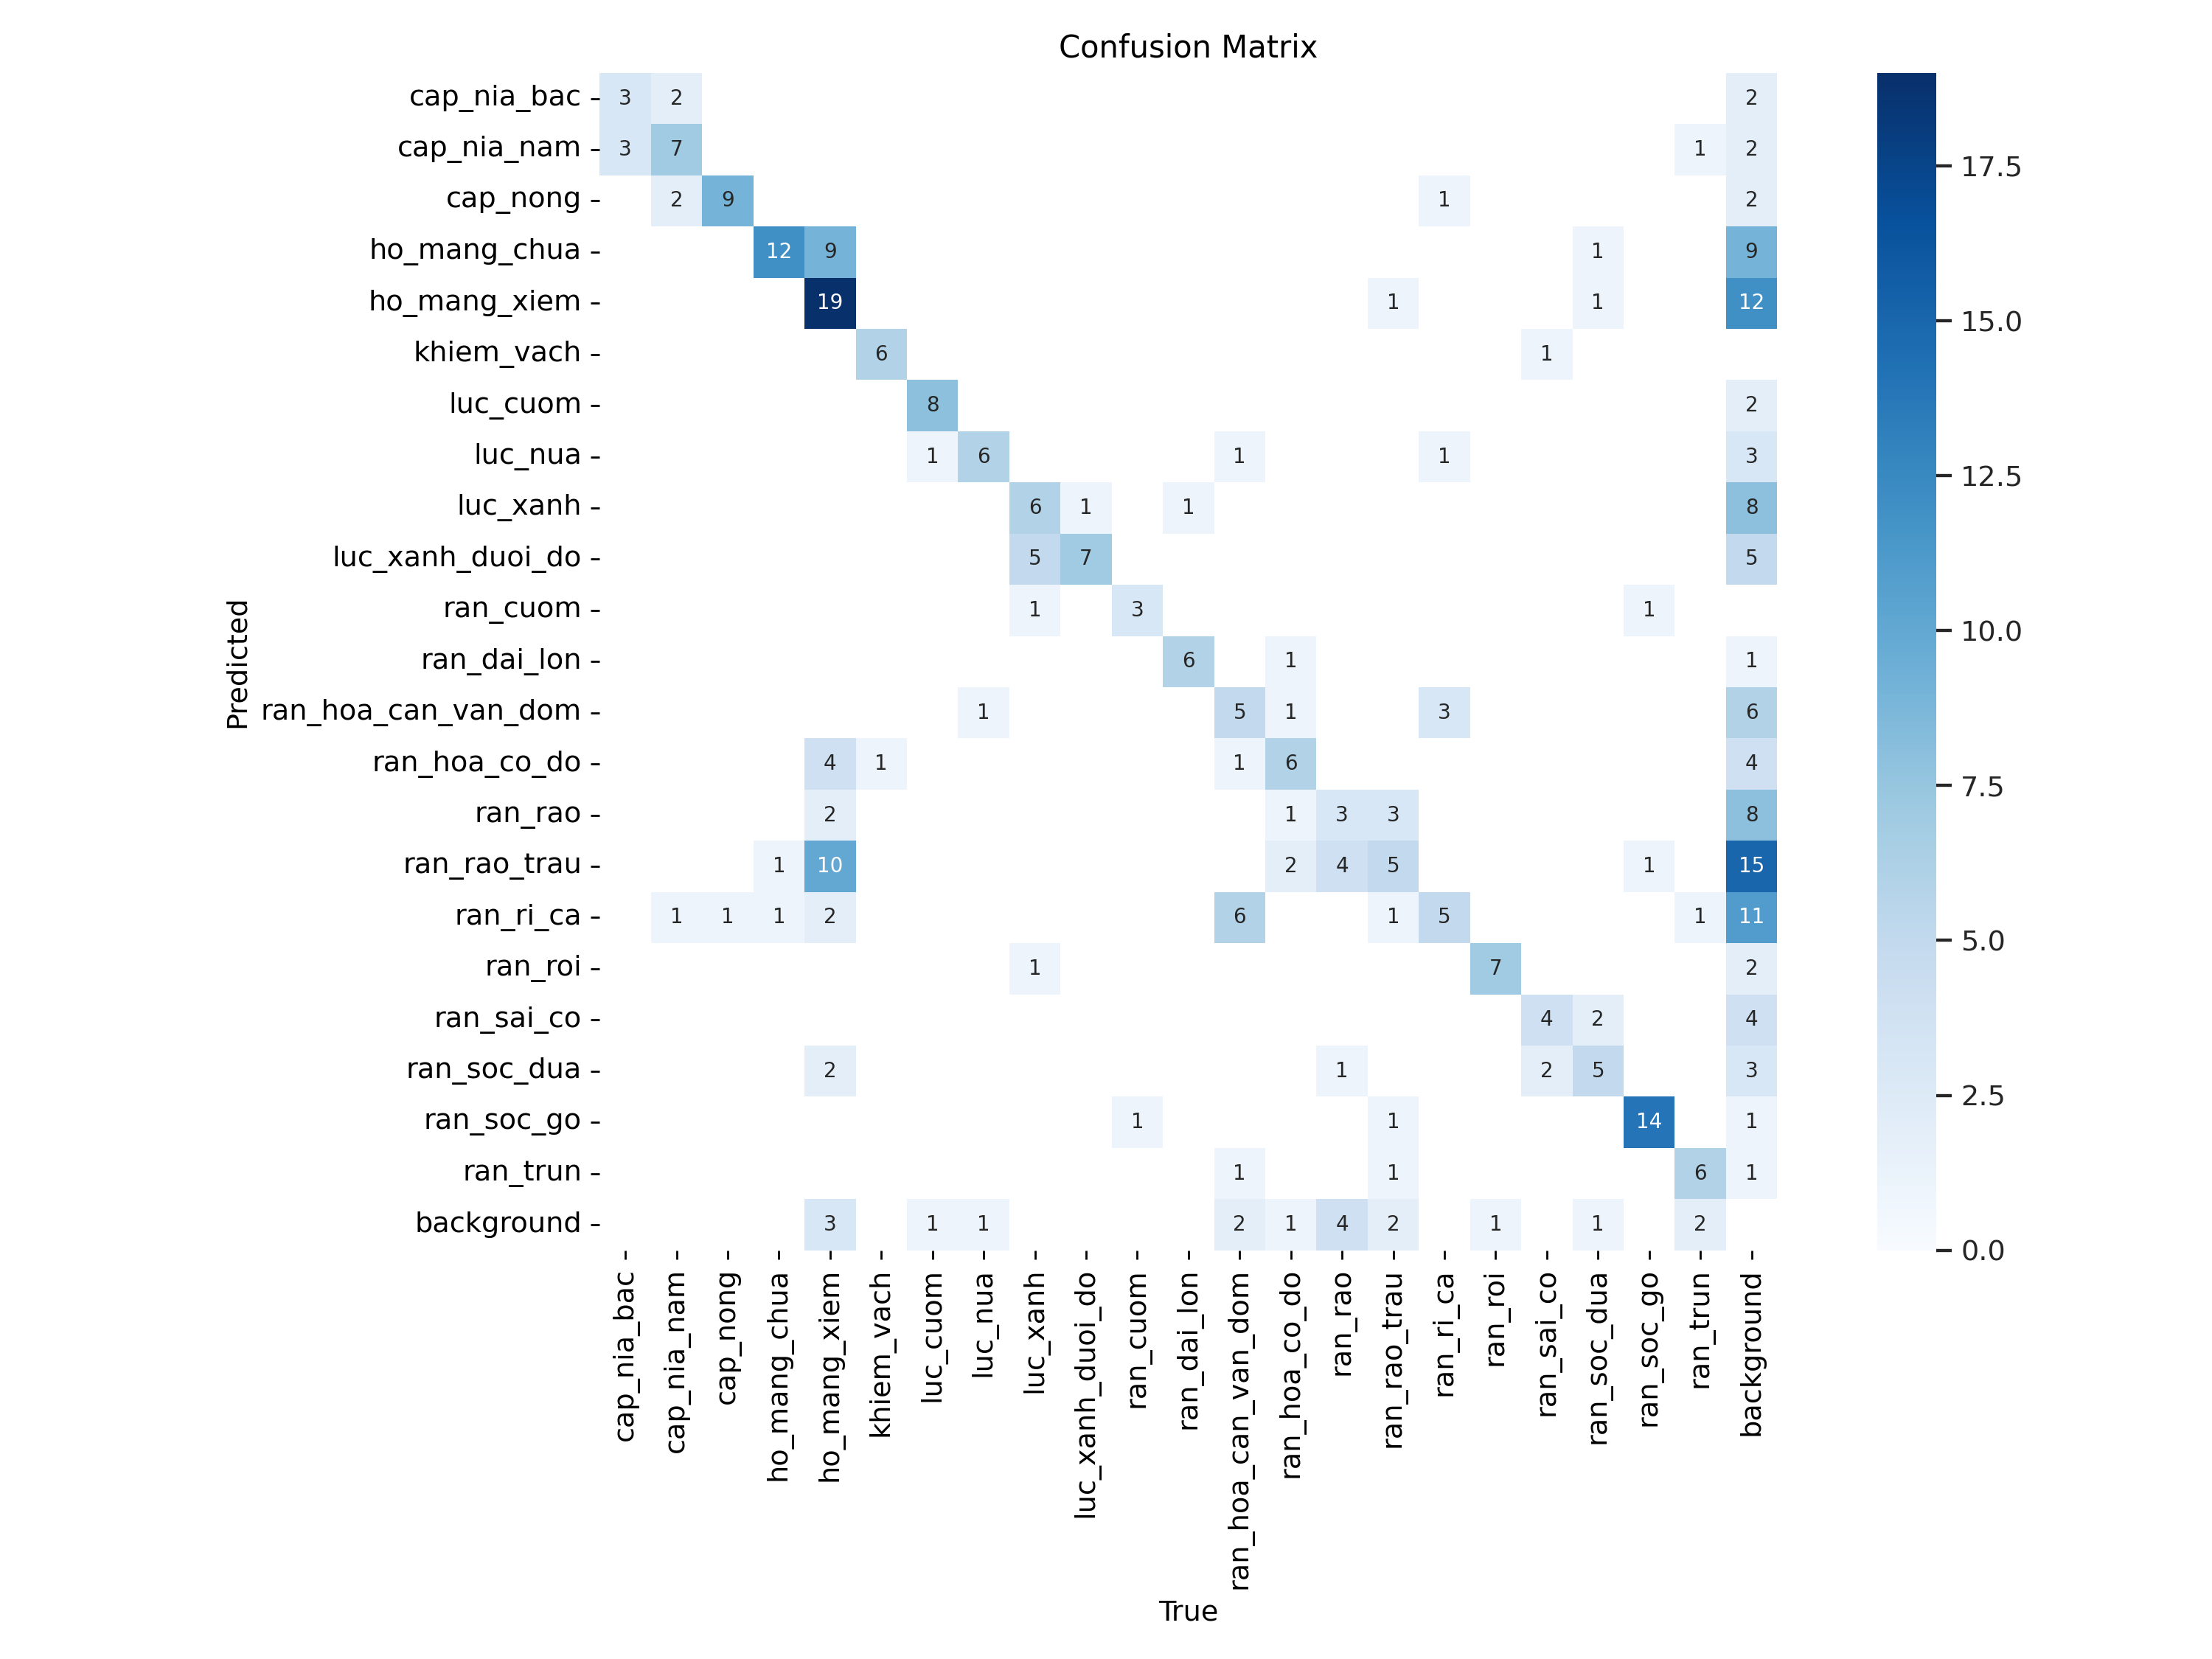

In [13]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

### Display Training Results Plot

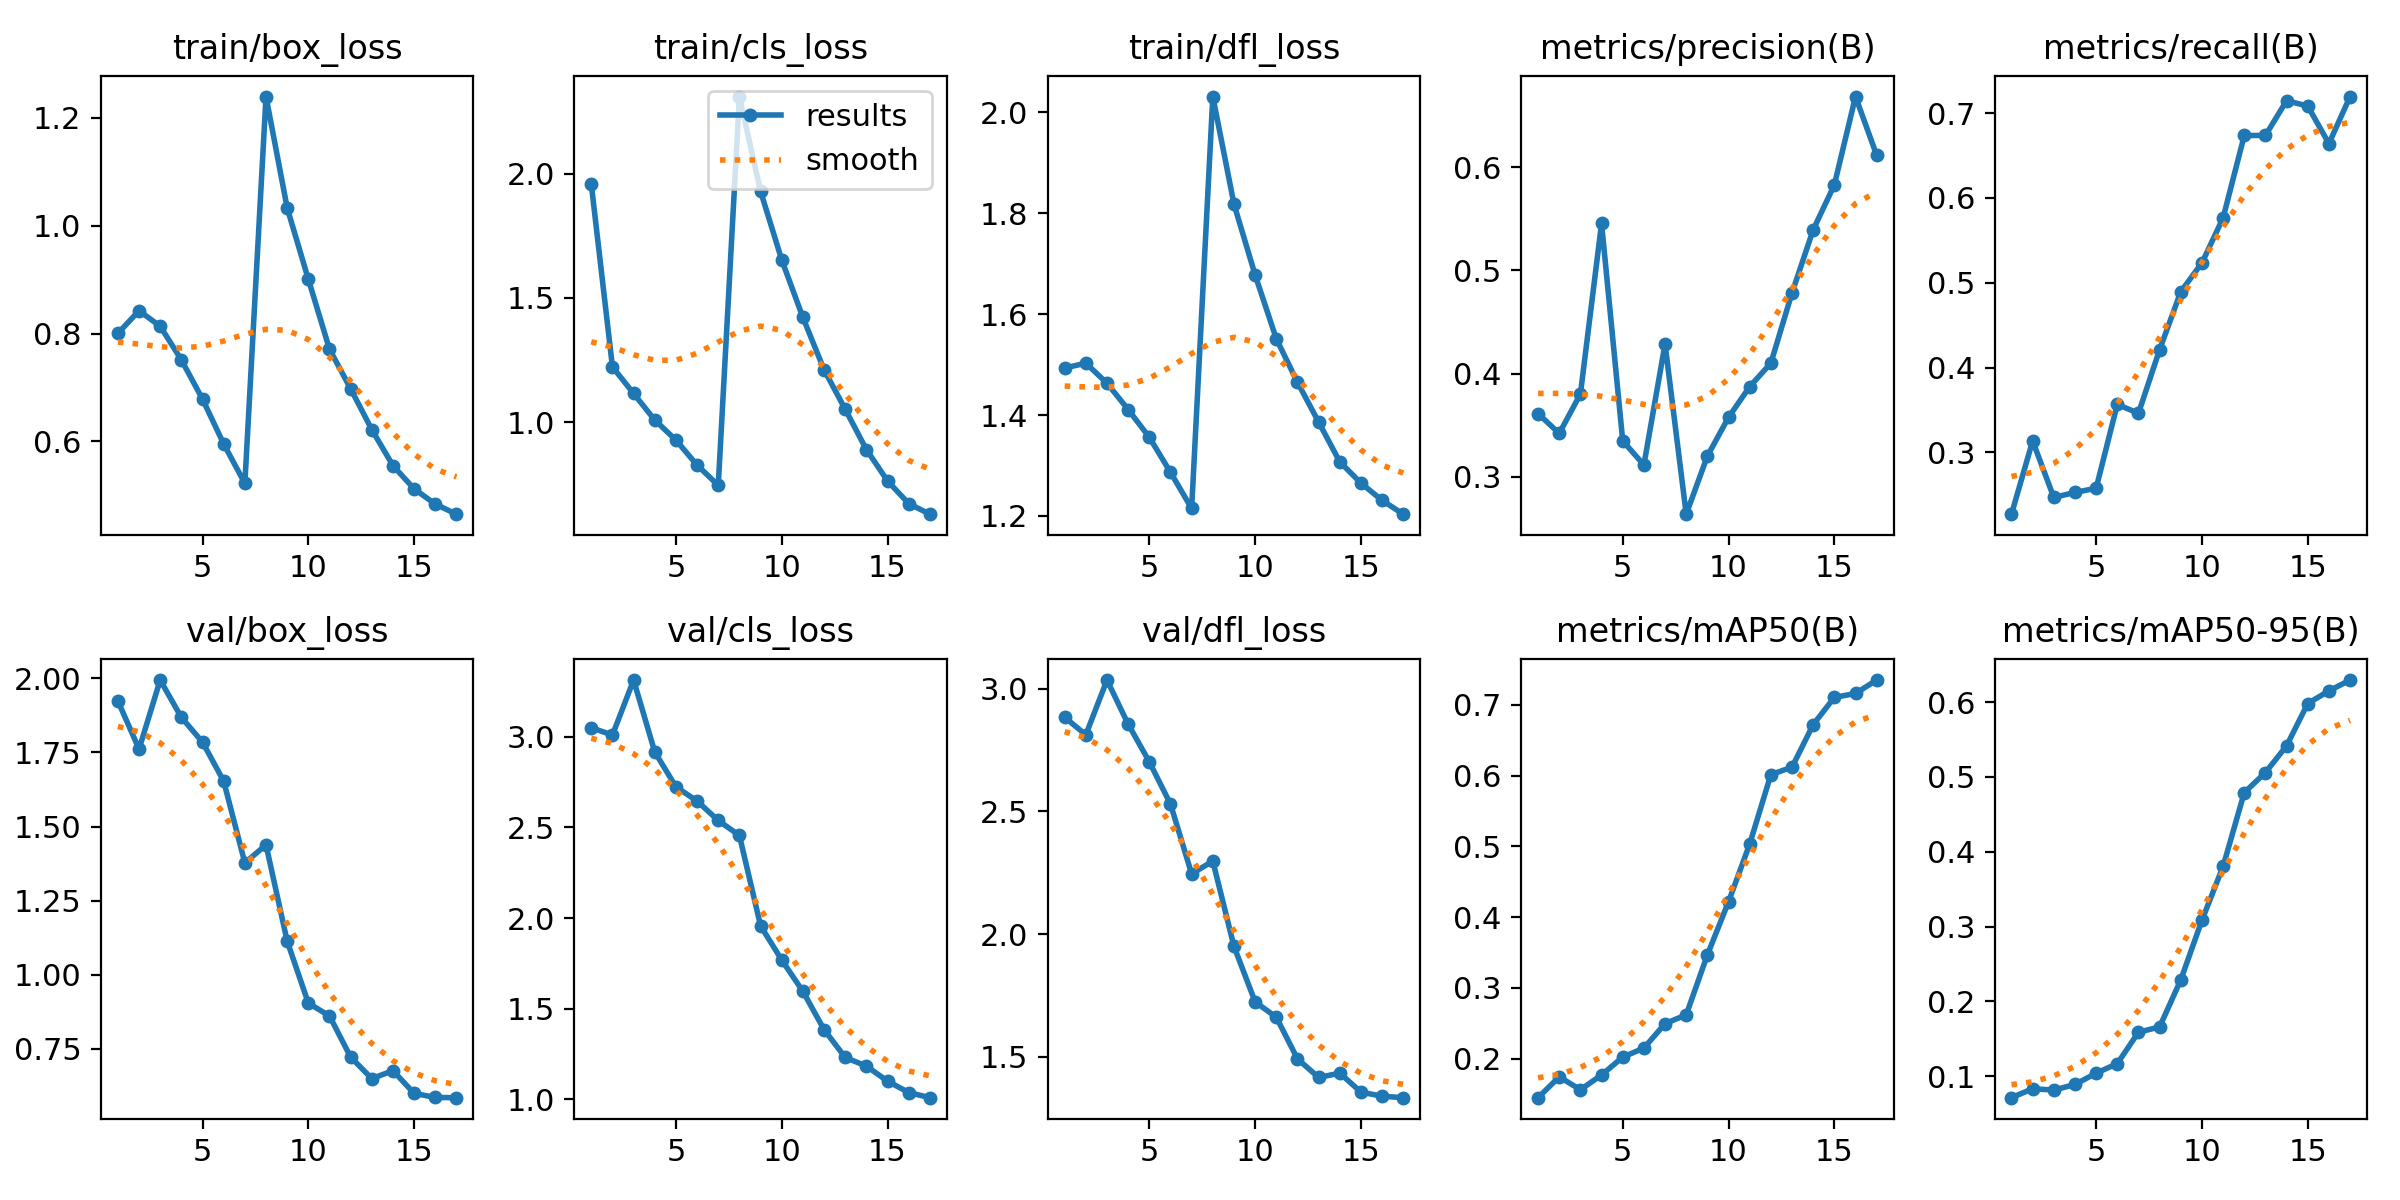

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

### Load Test Dataset and Display Classes

In [15]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{DATASET_PATH}/test/images",
    annotations_directory_path=f"{DATASET_PATH}/test/labels",
    data_yaml_path=DATA_YAML_PATH
)

ds.classes

['cap_nia_bac',
 'cap_nia_nam',
 'cap_nong',
 'ho_mang_chua',
 'ho_mang_xiem',
 'khiem_vach',
 'luc_cuom',
 'luc_nua',
 'luc_xanh',
 'luc_xanh_duoi_do',
 'ran_cuom',
 'ran_dai_lon',
 'ran_hoa_can_van_dom',
 'ran_hoa_co_do',
 'ran_rao',
 'ran_rao_trau',
 'ran_ri_ca',
 'ran_roi',
 'ran_sai_co',
 'ran_soc_dua',
 'ran_soc_go',
 'ran_trun']

### Calculate Mean Average Precision (mAP)

In [16]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

### Print mAP Scores

In [17]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.49041179786060524

mAP 50 0.5996331257751149

mAP 75 0.5192489704617755

### Plot mAP Curve

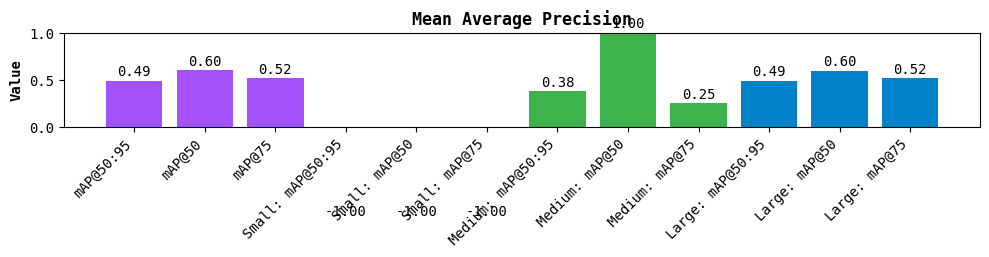

In [18]:
map.plot()

# Run inference with fine-tuned YOLOv12 model

In [19]:
import supervision as sv

model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{DATASET_PATH}/test/images",
    annotations_directory_path=f"{DATASET_PATH}/test/labels",
    data_yaml_path=DATA_YAML_PATH
)

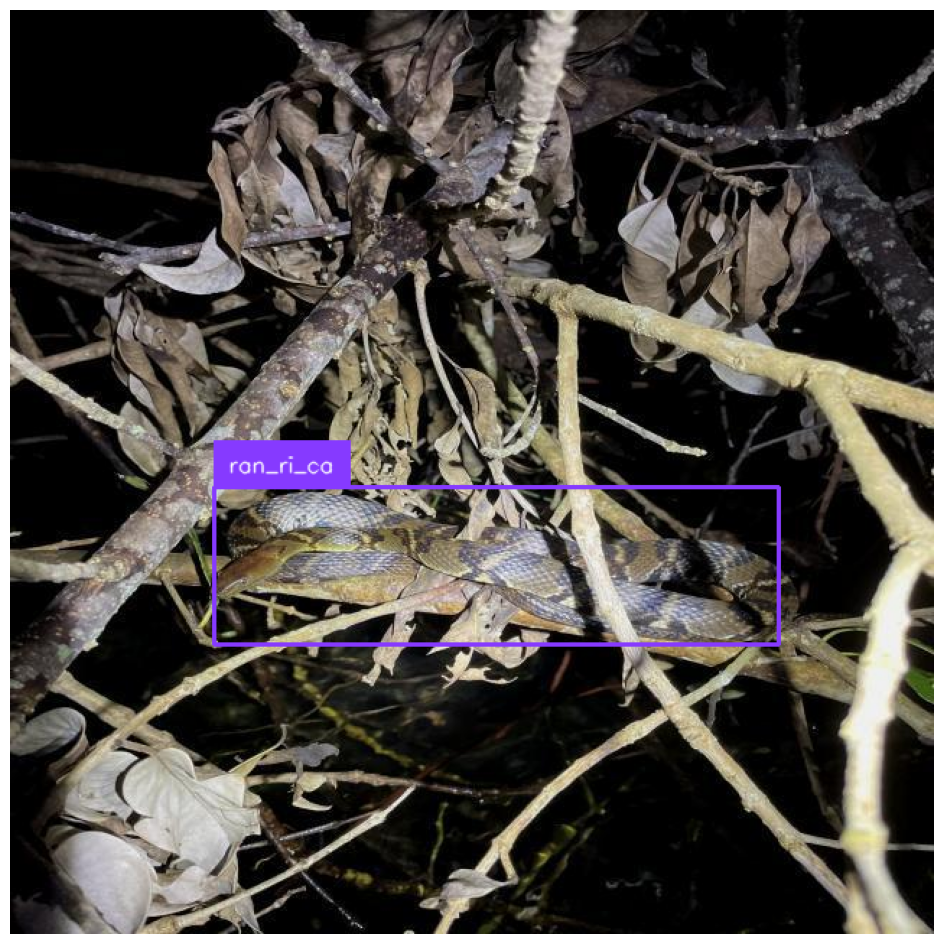

In [20]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

# Call tắt laptop sau khi train xong

In [21]:
import requests

WEBHOOK_URL = "https://forcepslike-lawanda-semicalcined.ngrok-free.dev/done"  # đổi URL của bạn

try:
    r = requests.post(WEBHOOK_URL)
    print("Đã gửi tín hiệu shutdown về PC!")
except Exception as e:
    print("Không gửi được webhook:", e)

Đã gửi tín hiệu shutdown về PC!